In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 12:17 - loss: 0.0600 - STD: 2.8061e-04 - MAE: 0.2276

 10/632 [..............................] - ETA: 3s - loss: 0.0246 - STD: 2.5074e-04 - MAE: 0.1217   

 17/632 [..............................] - ETA: 4s - loss: 0.0196 - STD: 2.1563e-04 - MAE: 0.1065

 25/632 [>.............................] - ETA: 4s - loss: 0.0170 - STD: 2.1940e-04 - MAE: 0.1007

 33/632 [>.............................] - ETA: 4s - loss: 0.0154 - STD: 2.2821e-04 - MAE: 0.0945

 41/632 [>.............................] - ETA: 3s - loss: 0.0144 - STD: 2.5587e-04 - MAE: 0.0919

 48/632 [=>............................] - ETA: 3s - loss: 0.0138 - STD: 2.8375e-04 - MAE: 0.0899

 55/632 [=>............................] - ETA: 3s - loss: 0.0133 - STD: 3.1436e-04 - MAE: 0.0880

 62/632 [=>............................] - ETA: 3s - loss: 0.0129 - STD: 3.5615e-04 - MAE: 0.0869

 70/632 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 4.1324e-04 - MAE: 0.0859

 78/632 [==>...........................] - ETA: 3s - loss: 0.0122 - STD: 4.8622e-04 - MAE: 0.0850

 85/632 [===>..........................] - ETA: 3s - loss: 0.0121 - STD: 5.7439e-04 - MAE: 0.0845

 89/632 [===>..........................] - ETA: 3s - loss: 0.0120 - STD: 6.3405e-04 - MAE: 0.0842

 96/632 [===>..........................] - ETA: 3s - loss: 0.0118 - STD: 7.6717e-04 - MAE: 0.0837

104/632 [===>..........................] - ETA: 3s - loss: 0.0116 - STD: 9.7976e-04 - MAE: 0.0832

112/632 [====>.........................] - ETA: 3s - loss: 0.0115 - STD: 0.0013 - MAE: 0.0828    

120/632 [====>.........................] - ETA: 3s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0823

128/632 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 0.0025 - MAE: 0.0819

136/632 [=====>........................] - ETA: 3s - loss: 0.0110 - STD: 0.0036 - MAE: 0.0813

143/632 [=====>........................] - ETA: 3s - loss: 0.0109 - STD: 0.0048 - MAE: 0.0809

151/632 [======>.......................] - ETA: 3s - loss: 0.0108 - STD: 0.0063 - MAE: 0.0803

159/632 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0077 - MAE: 0.0798

167/632 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.0092 - MAE: 0.0793

174/632 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.0104 - MAE: 0.0788

182/632 [=======>......................] - ETA: 3s - loss: 0.0103 - STD: 0.0117 - MAE: 0.0784

187/632 [=======>......................] - ETA: 3s - loss: 0.0102 - STD: 0.0125 - MAE: 0.0781

195/632 [========>.....................] - ETA: 3s - loss: 0.0101 - STD: 0.0138 - MAE: 0.0777

203/632 [========>.....................] - ETA: 3s - loss: 0.0100 - STD: 0.0149 - MAE: 0.0772

211/632 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 0.0160 - MAE: 0.0768

219/632 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0171 - MAE: 0.0763

227/632 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0182 - MAE: 0.0758

235/632 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0195 - MAE: 0.0753

243/632 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0207 - MAE: 0.0747

251/632 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 0.0219 - MAE: 0.0743

258/632 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 0.0230 - MAE: 0.0739

266/632 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0241 - MAE: 0.0733

274/632 [============>.................] - ETA: 2s - loss: 0.0091 - STD: 0.0251 - MAE: 0.0730

281/632 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0259 - MAE: 0.0726

285/632 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0264 - MAE: 0.0723

292/632 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0272 - MAE: 0.0720

300/632 [=============>................] - ETA: 2s - loss: 0.0088 - STD: 0.0281 - MAE: 0.0716

308/632 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0291 - MAE: 0.0712

316/632 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0300 - MAE: 0.0708

324/632 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0309 - MAE: 0.0704

332/632 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0317 - MAE: 0.0700

340/632 [===============>..............] - ETA: 2s - loss: 0.0084 - STD: 0.0325 - MAE: 0.0697

348/632 [===============>..............] - ETA: 2s - loss: 0.0083 - STD: 0.0332 - MAE: 0.0693

356/632 [===============>..............] - ETA: 1s - loss: 0.0082 - STD: 0.0340 - MAE: 0.0689

364/632 [================>.............] - ETA: 1s - loss: 0.0082 - STD: 0.0347 - MAE: 0.0686

372/632 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0355 - MAE: 0.0683

380/632 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0360 - MAE: 0.0680

385/632 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0364 - MAE: 0.0678

394/632 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0371 - MAE: 0.0674

403/632 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0378 - MAE: 0.0671

411/632 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0384 - MAE: 0.0668

418/632 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0389 - MAE: 0.0666

428/632 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0397 - MAE: 0.0662

436/632 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0402 - MAE: 0.0660

443/632 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0406 - MAE: 0.0658

447/632 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0408 - MAE: 0.0657

454/632 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0412 - MAE: 0.0655

462/632 [====================>.........] - ETA: 1s - loss: 0.0075 - STD: 0.0417 - MAE: 0.0652

470/632 [=====================>........] - ETA: 1s - loss: 0.0075 - STD: 0.0422 - MAE: 0.0650

478/632 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0426 - MAE: 0.0648

486/632 [======================>.......] - ETA: 1s - loss: 0.0074 - STD: 0.0431 - MAE: 0.0646

494/632 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0434 - MAE: 0.0644

501/632 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0437 - MAE: 0.0643

508/632 [=======================>......] - ETA: 1s - loss: 0.0073 - STD: 0.0441 - MAE: 0.0641

516/632 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0445 - MAE: 0.0639

523/632 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0449 - MAE: 0.0637

531/632 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0453 - MAE: 0.0635

539/632 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0457 - MAE: 0.0633

545/632 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0460 - MAE: 0.0632

551/632 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0462 - MAE: 0.0630

559/632 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0466 - MAE: 0.0629

567/632 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0469 - MAE: 0.0627

575/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0472 - MAE: 0.0626

583/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0475 - MAE: 0.0624

591/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0479 - MAE: 0.0622

599/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0482 - MAE: 0.0621

606/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0484 - MAE: 0.0620

614/632 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0487 - MAE: 0.0618

621/632 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0490 - MAE: 0.0617

629/632 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0616

632/632 [==============================] - 7s 9ms/step - loss: 0.0068 - STD: 0.0493 - MAE: 0.0615 - val_loss: 0.0043 - val_STD: 0.0528 - val_MAE: 0.0473


Epoch 2/10000


  1/632 [..............................] - ETA: 22s - loss: 0.0042 - STD: 0.0662 - MAE: 0.0474

  8/632 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0499 

 15/632 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

 23/632 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

 29/632 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

 36/632 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

 44/632 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

 51/632 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

 59/632 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

 67/632 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

 75/632 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

 83/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

 91/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

 99/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

107/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

114/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

122/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

127/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

135/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

143/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

151/632 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

159/632 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

166/632 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

175/632 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

183/632 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

191/632 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

199/632 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

207/632 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

215/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

222/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

227/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

236/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

245/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

254/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

262/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

270/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

276/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

284/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

291/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

299/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

307/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

315/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

323/632 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

331/632 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

339/632 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

347/632 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

355/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

363/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

371/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

379/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

384/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

390/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

398/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

406/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

414/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

422/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

429/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

437/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

445/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

453/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

461/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

469/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

477/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

482/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

487/632 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

494/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

502/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

510/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

518/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

526/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

534/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

542/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

550/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

557/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

565/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

572/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

579/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

584/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

592/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

600/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

608/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

614/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

622/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

630/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

632/632 [==============================] - 5s 8ms/step - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492 - val_loss: 0.0038 - val_STD: 0.0607 - val_MAE: 0.0460


Epoch 3/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

  8/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0473 

 16/632 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

 23/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

 28/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0473

 33/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

 40/632 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

 48/632 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

 56/632 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0472

 64/632 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

 71/632 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

 79/632 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

 86/632 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

 94/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

102/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

110/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

118/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

124/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

129/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

137/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

145/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

153/632 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

161/632 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

169/632 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

177/632 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

185/632 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

193/632 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

201/632 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

209/632 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

216/632 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

223/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

228/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

237/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

246/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

254/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

262/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

268/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

275/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

283/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

291/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

299/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

307/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

315/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

323/632 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

330/632 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

338/632 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

346/632 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

354/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

362/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

370/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

377/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

382/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

389/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

397/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

405/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

413/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

421/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

429/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

437/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

445/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

453/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

461/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

469/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

475/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

481/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

489/632 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

497/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

504/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

511/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

519/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

527/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

535/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

543/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

551/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

559/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

567/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

573/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

578/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

586/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

594/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

602/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

610/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

618/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

626/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

632/632 [==============================] - 5s 8ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470 - val_loss: 0.0036 - val_STD: 0.0605 - val_MAE: 0.0438


Epoch 4/10000


  1/632 [..............................] - ETA: 20s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0465

  9/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463 

 16/632 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 24/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

 30/632 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

 38/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

 46/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

 54/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

 62/632 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

 70/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

 78/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

 86/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

 94/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

102/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

110/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

118/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

125/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

129/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

136/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

144/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

152/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

160/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

168/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

176/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

184/632 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

192/632 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

200/632 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

208/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

216/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

224/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

229/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

238/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

247/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

255/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

263/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

270/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

277/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

285/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

293/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

301/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

309/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

317/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

325/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

331/632 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

339/632 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

347/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

355/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

363/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

371/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

379/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

383/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

390/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

398/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

406/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

413/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

420/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

428/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

436/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

444/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

452/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

460/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

468/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

476/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

484/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

492/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

500/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

508/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

513/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

518/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

526/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

534/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

542/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

550/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

557/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

564/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

572/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

580/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

588/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

596/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

604/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

612/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

616/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

622/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

629/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

632/632 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0610 - val_MAE: 0.0439


Epoch 5/10000


  1/632 [..............................] - ETA: 22s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0422

  8/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0445 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

 24/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

 32/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 37/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

 44/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

 51/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

 59/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

 67/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

 75/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

 83/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

 91/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

 99/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

107/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

115/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

123/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

131/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

135/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

142/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

150/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

158/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

166/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

174/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

182/632 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

190/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

198/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

206/632 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

214/632 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

221/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

229/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

234/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

242/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

251/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

259/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

267/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

274/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

281/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

289/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

297/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

305/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

313/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

321/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

329/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

337/632 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

345/632 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

353/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

361/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

369/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

377/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

385/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

389/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

397/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

405/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

413/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

421/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

429/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

437/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

445/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

453/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

461/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

469/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

477/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

484/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

489/632 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

497/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

505/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

513/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

519/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

527/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

535/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

543/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

551/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

559/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

567/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

575/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

583/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

591/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

599/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

607/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

614/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

619/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

627/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

632/632 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0622 - val_MAE: 0.0438


Epoch 6/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0452

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436 

 17/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

 25/632 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

 33/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

 41/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

 46/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

 53/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

 61/632 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

 69/632 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

 76/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

 83/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

 91/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

 99/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

113/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

121/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

129/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

137/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

143/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

149/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

157/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

164/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

172/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

180/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

188/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

196/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

204/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

212/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

220/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

228/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

236/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

242/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

250/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

259/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

267/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

275/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

283/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

289/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

297/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

305/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

313/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

321/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

329/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

337/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

345/632 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

352/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

360/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

368/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

376/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

384/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

392/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

397/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

404/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

412/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

420/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

428/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

436/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

444/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

452/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

460/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

468/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

476/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

484/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

492/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

498/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

503/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

511/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

519/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

527/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

535/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

543/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

551/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

559/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

567/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

575/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

583/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

591/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

598/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

603/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

611/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

619/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

627/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

632/632 [==============================] - 5s 7ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0630 - val_MAE: 0.0432


Epoch 7/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0405

  7/632 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0821 - MAE: 0.0433 

 14/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

 19/632 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 25/632 [>.............................] - ETA: 5s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0434

 33/632 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0431

 41/632 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

 49/632 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 56/632 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

 64/632 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 71/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 78/632 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

 86/632 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

 94/632 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

102/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

110/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

118/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

126/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

134/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

147/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

153/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

161/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

169/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

177/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

185/632 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

193/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

201/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

209/632 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

217/632 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

225/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

233/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

241/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

246/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

253/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

262/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

270/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

278/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

286/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

291/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

299/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

307/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

314/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

322/632 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

330/632 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

337/632 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

344/632 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

349/632 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

355/632 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

362/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

371/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

379/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

388/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

396/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

405/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

414/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

423/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

432/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

441/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

449/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

458/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

467/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

476/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

485/632 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

493/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

502/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

511/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

520/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

529/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

538/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

547/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

556/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

565/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

574/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

583/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

591/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

600/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

609/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

618/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

627/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

632/632 [==============================] - 5s 7ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0622 - val_MAE: 0.0431


Epoch 8/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

  9/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0424 

 18/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0421

 27/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0422

 36/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0421

 45/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

 54/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

 63/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

 71/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0429

 78/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

 86/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

 94/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

102/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

110/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

118/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0429

126/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

134/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

142/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

147/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

153/632 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

161/632 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

170/632 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

179/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

188/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

196/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0429

205/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

214/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

223/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

231/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

240/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

249/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

258/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

267/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

275/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

284/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

293/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

302/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

311/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

320/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

329/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

338/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

347/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

356/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

365/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

374/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

383/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

392/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

401/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

410/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

420/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

429/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

438/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

447/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

456/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

465/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

474/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

483/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

492/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

501/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

510/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

519/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

528/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

537/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

545/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

553/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

560/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

568/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

576/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

582/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

588/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

597/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

606/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

615/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

624/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0429

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0429 - val_loss: 0.0037 - val_STD: 0.0645 - val_MAE: 0.0460


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0460

 10/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0423 

 19/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0422

 28/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

 37/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0424

 46/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0423

 55/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0424

 63/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

 72/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0423

 81/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0423

 91/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

100/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

109/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0423

118/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

127/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0422

136/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

145/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

154/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

163/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

172/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

181/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

190/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

199/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

208/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

217/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

225/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

234/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

243/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

252/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

260/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

269/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

277/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

285/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

293/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

301/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

306/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

312/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

319/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

328/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

337/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

345/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

354/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

363/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

372/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

381/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

390/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

399/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

408/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

417/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

426/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

435/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

444/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

453/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

462/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

471/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

480/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

489/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

498/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

507/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

516/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

525/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

534/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

543/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

552/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

561/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

570/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

579/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

588/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

597/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

606/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

614/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

623/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

632/632 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423 - val_loss: 0.0036 - val_STD: 0.0656 - val_MAE: 0.0444


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0034 - STD: 0.0835 - MAE: 0.0434

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435 

 17/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0430

 25/632 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 33/632 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0422

 41/632 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

 49/632 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

 55/632 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

 60/632 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0422

 67/632 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

 76/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

 85/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0423

 94/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

103/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

112/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

121/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

130/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

139/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

148/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

156/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

165/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

174/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

183/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

192/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

201/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

210/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

219/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

228/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

237/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

246/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

255/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

265/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

274/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

283/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

292/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

301/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

310/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

319/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

328/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

337/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

346/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0422

355/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0422

364/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0422

373/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0422

382/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

391/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

400/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

409/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

418/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

427/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

435/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

443/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

451/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

459/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

467/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

473/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

480/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

489/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

498/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

507/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

516/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

525/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

534/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

543/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

552/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

561/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

569/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

578/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0421

587/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0421

596/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0421

605/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0421

614/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0421

623/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

632/632 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

632/632 [==============================] - 4s 7ms/step - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421 - val_loss: 0.0035 - val_STD: 0.0661 - val_MAE: 0.0431


Epoch 11/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0849 - MAE: 0.0427

 10/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410 

 19/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0410

 28/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

 37/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0411

 46/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

 55/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

 64/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

 73/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

 82/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

 91/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

100/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

109/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

118/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

127/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

136/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

145/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

154/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0415

163/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

172/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0415

181/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

189/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

196/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

203/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

211/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

220/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

229/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

238/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

247/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

256/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

265/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

274/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

283/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

292/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

301/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

310/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

319/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

328/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

337/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

346/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

355/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

364/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

372/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

380/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

388/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

396/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

402/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

408/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

417/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

426/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

435/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

444/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

453/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

462/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

471/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

479/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

488/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

497/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

506/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

515/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

524/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

533/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

542/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

551/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

560/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

569/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

578/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

587/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

596/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

605/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

614/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

623/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

632/632 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415 - val_loss: 0.0034 - val_STD: 0.0645 - val_MAE: 0.0425


Epoch 12/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0387

  9/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0417 

 18/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0820 - MAE: 0.0414

 27/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0413

 35/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0412

 43/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0410

 51/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0412

 59/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0413

 67/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0414

 75/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0414

 83/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

 90/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

 96/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

103/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

112/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

121/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0415

130/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0415

139/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0415

148/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0813 - MAE: 0.0415

156/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

165/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

174/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

182/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

191/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

199/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

208/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

217/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

226/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

235/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

243/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

251/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

260/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

269/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0414

278/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

287/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

296/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

305/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

314/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0413

323/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

332/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

341/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

350/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0413

359/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

368/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

377/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

386/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

395/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

404/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0412

413/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0412

422/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

431/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

440/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0413

448/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

456/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

464/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

472/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

480/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

487/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0413

494/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

503/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

512/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

521/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

528/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

535/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

544/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

553/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

562/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

571/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

580/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

589/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

598/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

607/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

616/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

625/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

632/632 [==============================] - 4s 7ms/step - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412 - val_loss: 0.0035 - val_STD: 0.0636 - val_MAE: 0.0425


Epoch 13/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0402

 10/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400 

 17/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

 26/632 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0813 - MAE: 0.0400

 35/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0816 - MAE: 0.0401

 44/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0402

 51/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0403

 59/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0405

 67/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0405

 76/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0405

 85/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0405

 94/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0405

103/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0406

112/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0406

121/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0407

130/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0407

139/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

148/632 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0408

157/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0408

166/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0408

175/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0408

184/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0408

193/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0408

200/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0408

208/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

217/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

226/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

234/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

241/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

250/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

259/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

268/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

277/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

286/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

295/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

304/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

313/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

321/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

330/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

339/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

348/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

357/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

366/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

375/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

384/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

392/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

400/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

408/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

416/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

423/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

431/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

439/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

447/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

455/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

463/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

472/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

480/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

489/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

498/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

507/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0408

515/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

523/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

532/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

541/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

550/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

559/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

568/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

577/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

586/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

595/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

603/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

612/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

621/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

629/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

632/632 [==============================] - 4s 7ms/step - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0435


Epoch 14/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0030 - STD: 0.0872 - MAE: 0.0412

 10/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0816 - MAE: 0.0402 

 18/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0406

 27/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

 36/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

 45/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

 54/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0401

 62/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

 71/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

 80/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0402

 89/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

105/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

113/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

122/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

131/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

140/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

149/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

157/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

166/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

175/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

184/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

193/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

202/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

211/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

220/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

229/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

238/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

247/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

256/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

265/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

273/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

281/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

289/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

298/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

307/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

316/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

325/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

334/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

343/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

352/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

361/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

371/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

380/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

389/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

398/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

407/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

416/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

425/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

433/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

442/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

451/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

460/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

468/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

476/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

485/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

494/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

503/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

512/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

521/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

530/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

539/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

548/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

557/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

566/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

575/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

584/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

593/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

602/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

611/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

620/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

629/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405 - val_loss: 0.0034 - val_STD: 0.0654 - val_MAE: 0.0420


Epoch 15/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0029 - STD: 0.0818 - MAE: 0.0390

  8/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437 

 17/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0424

 25/632 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0417

 31/632 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0414

 37/632 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0803 - MAE: 0.0411

 45/632 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 54/632 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0409

 63/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0408

 72/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

 81/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

 90/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0406

 99/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

108/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0405

117/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0404

126/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

135/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0405

144/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0404

153/632 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0404

162/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

171/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

180/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

189/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

198/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

206/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

215/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

224/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

233/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

242/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

251/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

260/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

269/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

278/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

287/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

296/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

305/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

315/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

324/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

333/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

342/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

351/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

360/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

369/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

378/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

387/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

396/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

405/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

414/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

422/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

431/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

440/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

449/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

458/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

467/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

475/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

484/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

493/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

502/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

511/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

520/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

529/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

538/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

547/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

556/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

565/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

574/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

583/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

592/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

601/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

609/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

616/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

625/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402 - val_loss: 0.0035 - val_STD: 0.0663 - val_MAE: 0.0426


Epoch 16/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0028 - STD: 0.0827 - MAE: 0.0387

  9/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407 

 17/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 26/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0831 - MAE: 0.0402

 35/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0832 - MAE: 0.0400

 44/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0828 - MAE: 0.0401

 53/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0399

 62/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0398

 69/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0398

 77/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0399

 86/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0399

 95/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

104/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

113/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

122/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

131/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

140/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

149/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0398

157/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

166/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

175/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

184/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

193/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

202/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

211/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

220/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

229/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

238/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

247/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

256/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

265/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

274/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

283/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

292/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

301/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

310/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

319/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

328/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

337/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

346/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

355/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

364/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

373/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

382/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

391/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

400/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

409/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

418/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

427/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

436/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

445/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

453/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

462/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

471/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

480/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

489/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

498/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

507/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

516/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

525/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

534/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

543/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

552/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

561/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

570/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

579/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

588/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

597/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

606/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

615/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

624/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399 - val_loss: 0.0035 - val_STD: 0.0635 - val_MAE: 0.0421


Epoch 17/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0775 - MAE: 0.0388

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0823 - MAE: 0.0394 

 18/632 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0823 - MAE: 0.0395

 27/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0399

 36/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

 45/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0406

 54/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

 63/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0406

 72/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

 80/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

 89/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

105/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0401

114/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

123/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

132/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

141/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

150/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

159/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

167/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

176/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

185/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

194/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

203/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

212/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

221/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

230/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0398

239/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

248/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

257/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

266/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

275/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

284/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

293/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

301/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

310/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

319/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

328/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

337/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

346/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

355/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

364/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

373/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

382/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

391/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

400/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

409/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

418/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

427/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

436/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

444/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

453/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

462/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

471/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

480/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

489/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

498/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

507/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

516/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

525/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

534/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

543/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

552/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

561/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

570/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

579/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

588/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

597/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

606/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

615/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

624/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396 - val_loss: 0.0035 - val_STD: 0.0646 - val_MAE: 0.0421


Epoch 18/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0815 - MAE: 0.0396 

 17/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0393

 26/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0836 - MAE: 0.0392

 35/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0837 - MAE: 0.0392

 44/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0391

 53/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0835 - MAE: 0.0391

 62/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0390

 71/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0390

 80/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0391

 89/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

 98/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

107/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

116/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

125/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

134/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

143/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

152/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

161/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

170/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

179/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

188/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

197/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

206/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

215/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

224/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

233/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

242/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

251/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0394

260/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

269/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

278/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

287/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

296/632 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

305/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

314/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

324/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

333/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

342/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

351/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

360/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

369/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

378/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

387/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

396/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

405/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

414/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

423/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

432/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0393

441/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0393

450/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

459/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

468/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

477/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

486/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

495/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

504/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

513/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

522/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

531/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

540/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

549/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

558/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

567/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

576/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

585/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

594/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

603/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

612/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

621/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

630/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

632/632 [==============================] - 4s 6ms/step - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393 - val_loss: 0.0037 - val_STD: 0.0669 - val_MAE: 0.0450


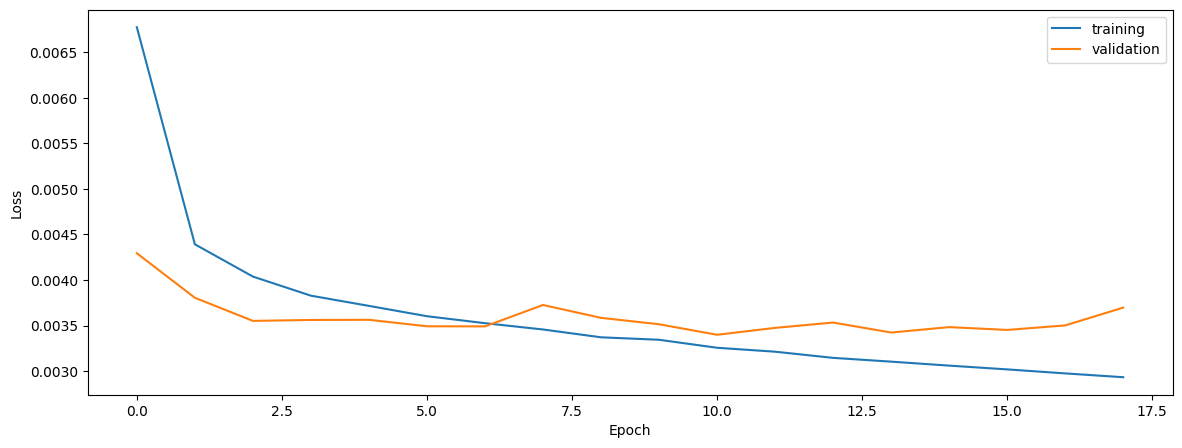

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8282653134746714
0.7995774434077879
0.8105959596456189


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8282653134746714
0.7995774434077879
0.8105959596456189


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8321180891395427
0.801049458650046
0.817407992749873


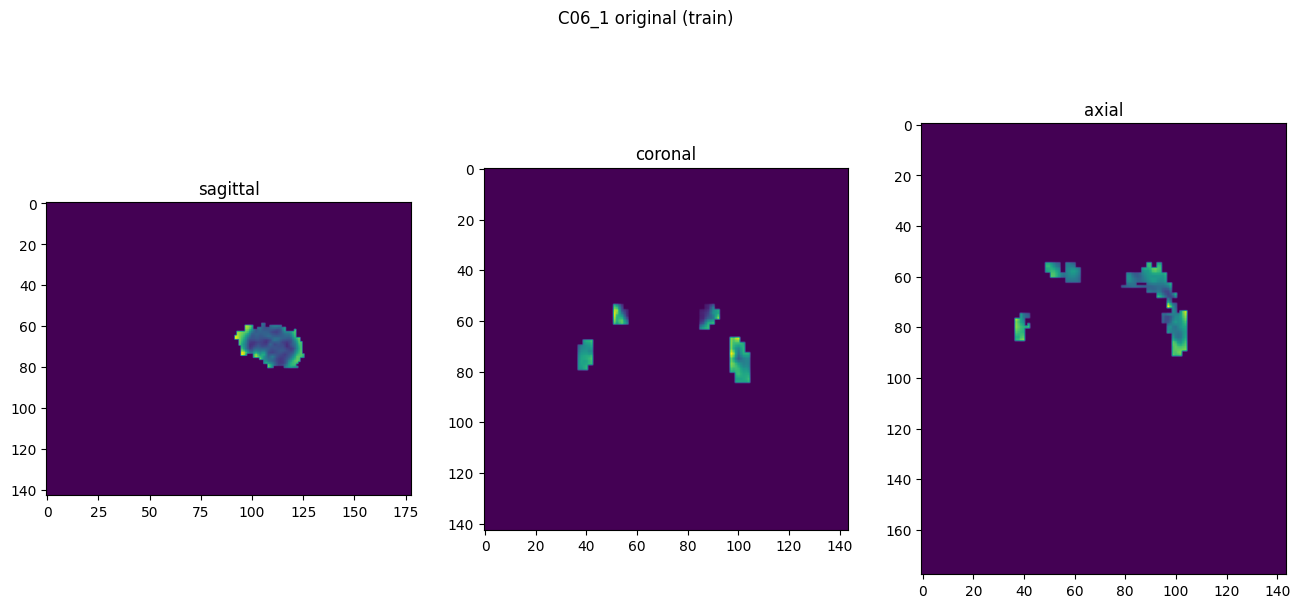

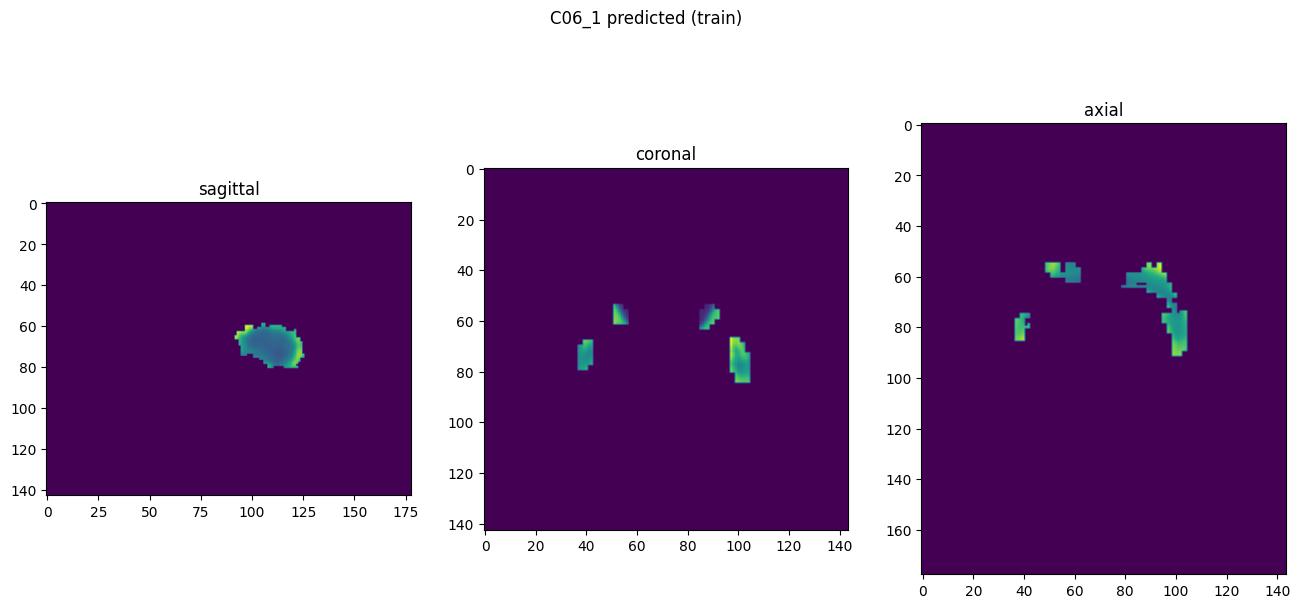

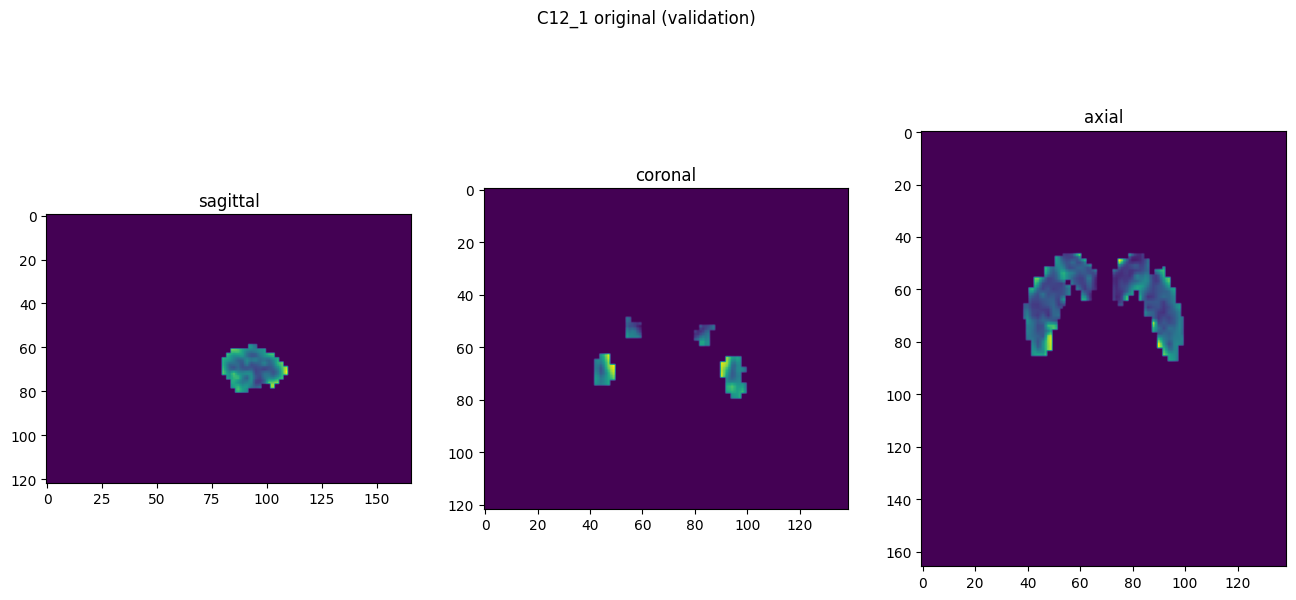

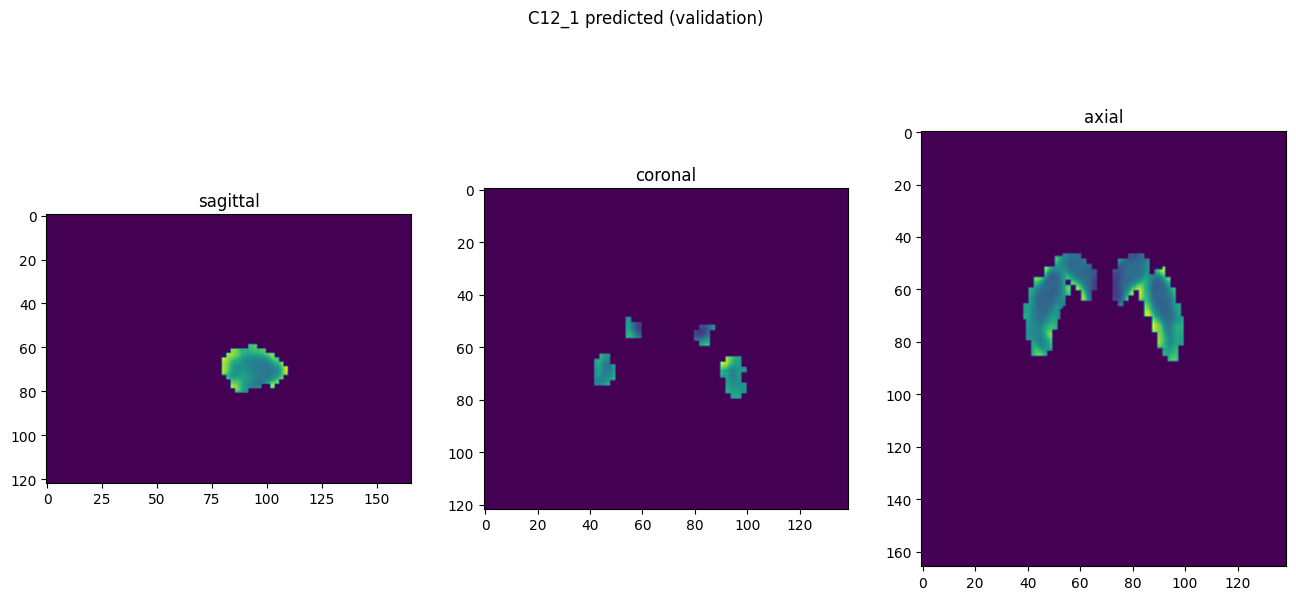

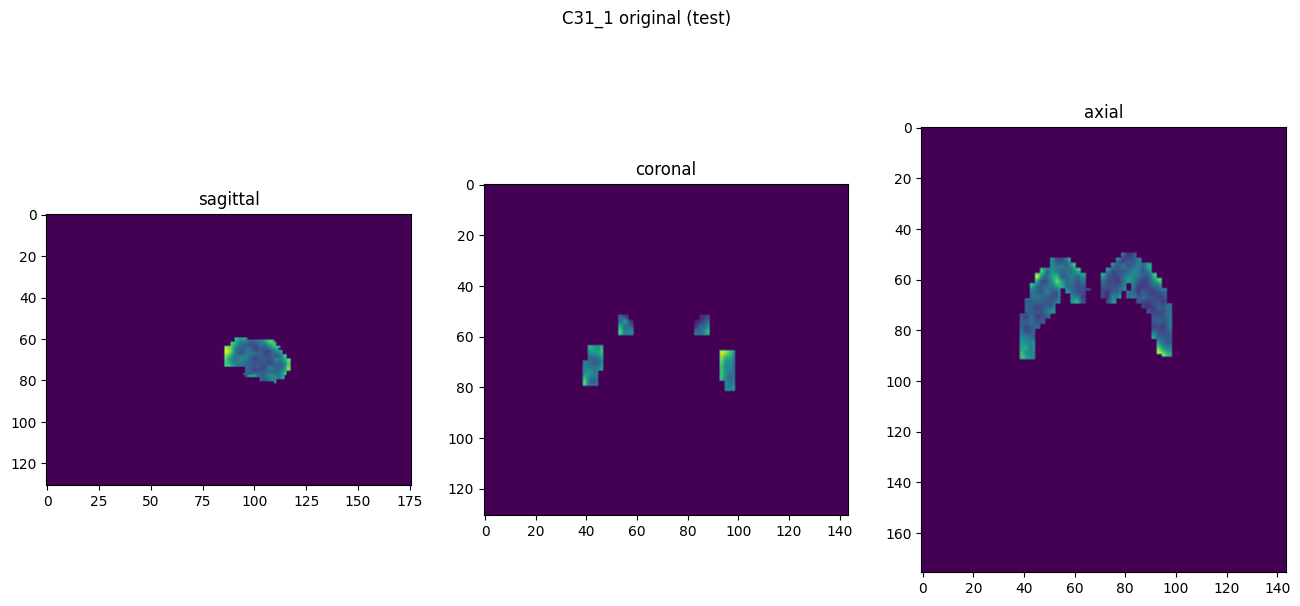

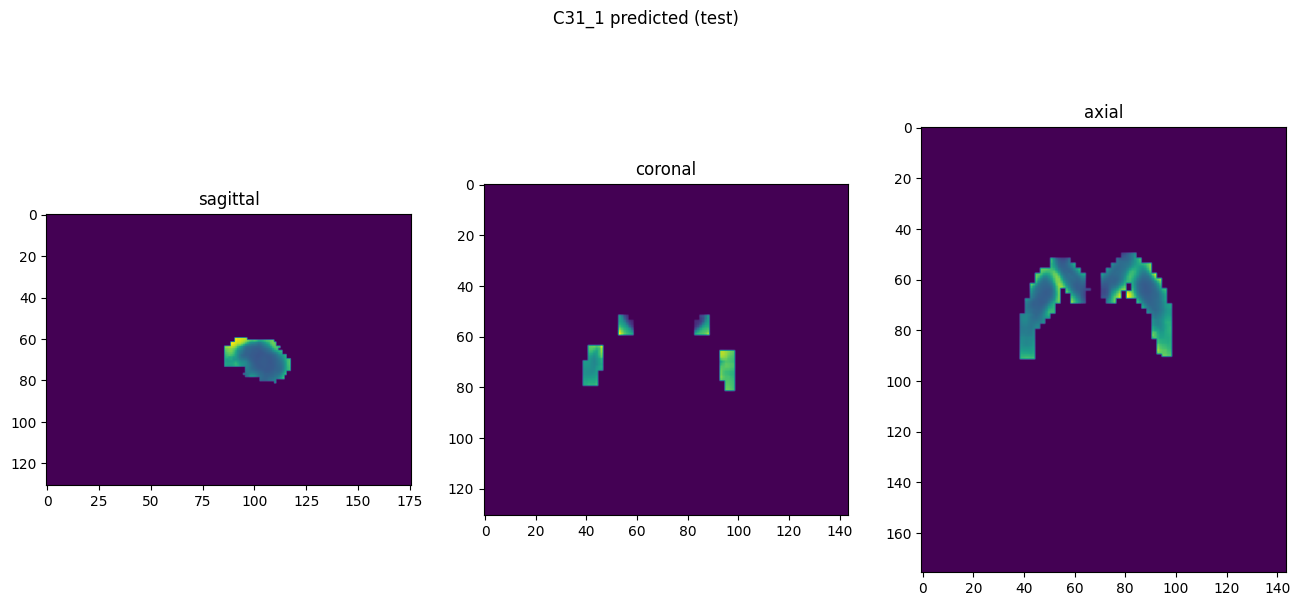

In [10]:
showResults(model, gen, threshold=None, background=False)